In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob

## Read

In [2]:
path = 'ADL_Dataset/HMP_Dataset'
folder_list = [folder_path for folder_path in os.listdir(path) if re.search('^((?!_M|txt|.m$).)*$', folder_path)]

In [3]:
def window_array(df, size=32, step=10):
    # slide window on df with step given size
    n = df.shape[0]
    end = int((n-size)/step)+1
    segments = np.vstack([np.array(df[(i*step):(i*step+size)]).T.reshape(1,size*3) for i in np.arange(end)])
    return pd.DataFrame(segments)

In [4]:
# window slicing vector for quantization
seg_list_dict = dict()
meta = dict()
for idx, folder_name in enumerate(folder_list):
    
    # update meta dict
    meta.update({idx: folder_name})
    
    # read elements in folder
    file_list = glob.glob(path+'/'+folder_list[idx]+"/*")
    # read file list data
    fileDataList = [ pd.read_table(file, header=None, delimiter=' ') for file in file_list]
    
    # convert each data to vector
    # split data into vector, 32 size
    seg_list = [window_array(fileData, size=32, step=16) for fileData in fileDataList]
    seg_list_dict.update({idx:seg_list})

In [5]:
# concat whole data for clustering
data_df = pd.concat([pd.concat(value) for key, value in seg_list_dict.items()])
data_df.shape

(26663, 96)

## Vector Quantization

In [45]:
%%time
from sklearn.cluster import KMeans

inertia = []
# ks = [15, 30, 40, 50, 100, 200, 400]
ks = [40]
kmeans = []
for k in ks:
    kmean = KMeans(n_clusters=k, n_init=40, max_iter=1000, n_jobs=3, random_state=1)
    kmean.fit(data_df)
    inertia.append(kmean.inertia_)
    kmeans.append(kmean)

Wall time: 1min 24s


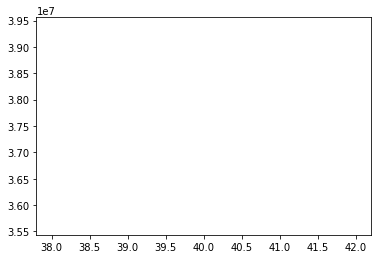

In [16]:
import matplotlib.pyplot as plt

plt.plot(ks, inertia)
plt.show()

## Histogram

In [10]:
# vector quantize segments
idx = 0
vq_dict = dict()
[vq_dict.update({key:[kmeans[idx].predict(value) for value in value_list]}) for key, value_list in  seg_list_dict.items()]
vq_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

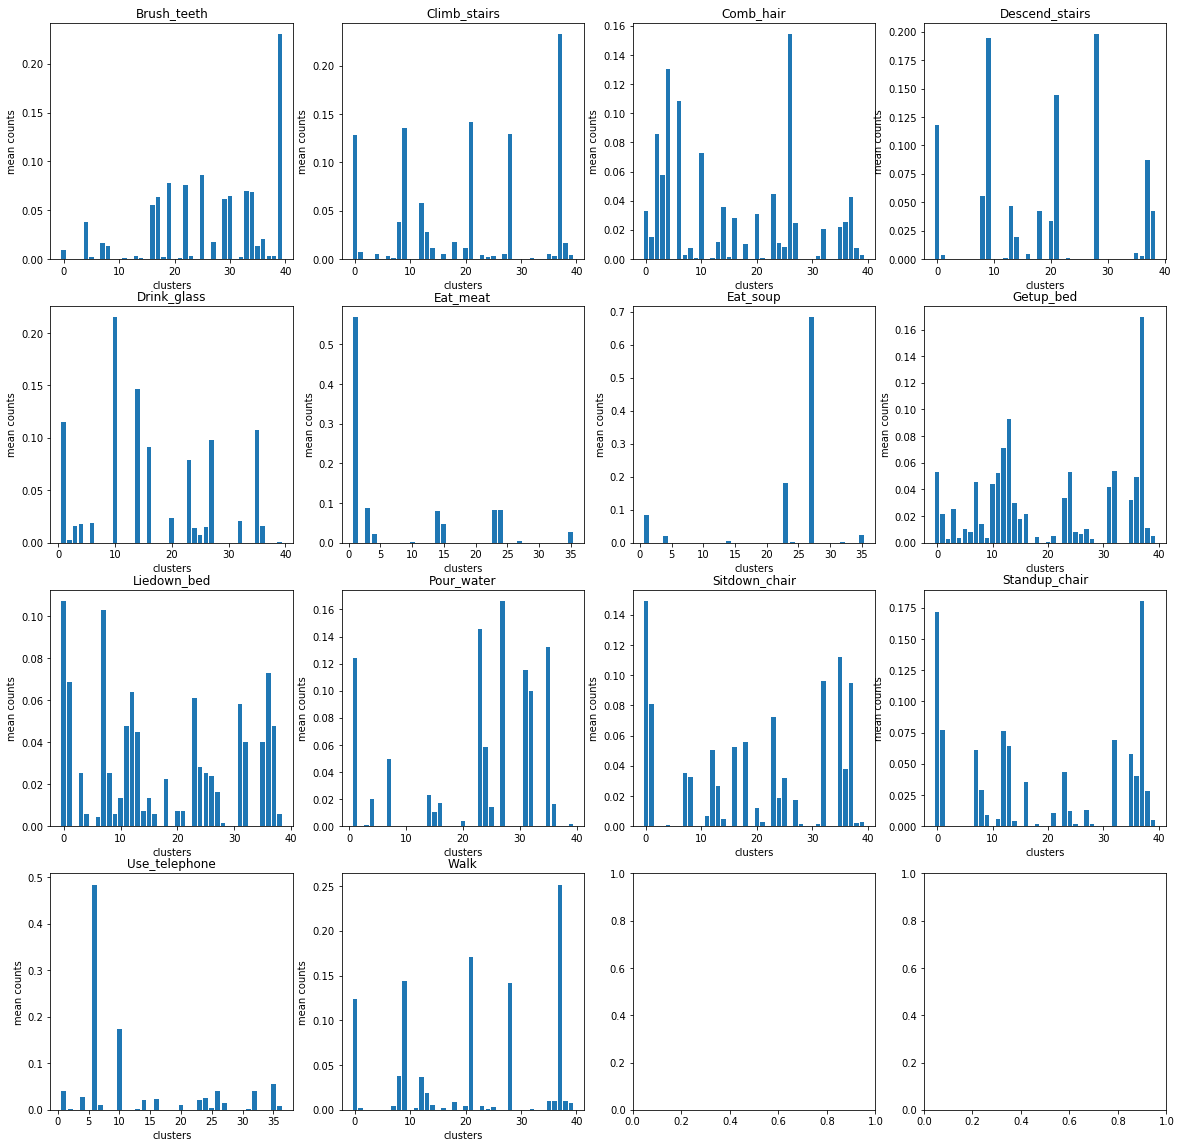

In [48]:
# Plot histogram
ncols = 4
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

i = 0
j = 0

for idx, value in vq_dict.items():
    ax = axes[i][j]
    ax.set_title(meta.get(idx))
    ax.set_xlabel('clusters')
    ax.set_ylabel('mean counts')
    unique, counts = np.unique(np.hstack(vq_dict.get(idx)), return_counts=True)
    ax.bar(unique, counts/np.sum(counts))
    fig.add_subplot(ax) #add 'ax' to figure
    
    if j == 3:
        i+=1
        j=0
    else:
        j+=1

## Classfier

In [12]:
def transform_feature(items, key):
    from collections import Counter
    # get list of clusters and count them and add label
    counts = Counter(items)
    n = np.sum(list(zip(*Counter(items).items()))[1])
    feature = pd.DataFrame(counts, index=[0], columns=np.arange(40))/n
    feature = feature.assign(cluster=key)
    return feature.fillna(0)

In [46]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

ks=[40]

for idx, k in enumerate(ks):

    # vector quantize segments
    vq_dict = dict()
    [vq_dict.update({key:[kmeans[idx].predict(value) for value in value_list]}) for key, value_list in  seg_list_dict.items()]

    # create feature matrix for modeling each file * K
    feature_mat = pd.concat([transform_feature(value, key) for key, value_list in vq_dict.items() for value in value_list])

    # stratified k-folds
    split= StratifiedKFold(n_splits=3, shuffle=True)
    X = feature_mat.iloc[:, :-1]
    y = feature_mat.iloc[:, -1]
    split.get_n_splits(X, y)

    accuracies = []
    result = 0
    for train_idx, test_idx in split.split(X, y):
        # train
        X_train=X.iloc[train_idx, :]
        y_train=y.iloc[train_idx]
        # test
        X_test=X.iloc[test_idx, :]
        y_test=y.iloc[test_idx]
        
        classifier = RandomForestClassifier(n_estimators=1500, n_jobs=3, random_state=1)
        classifier.fit(X_train, y_train)

        pred = classifier.predict(X_test)
        result += confusion_matrix(y_test, pred)
        accuracies.append(np.mean(pred==y_test))

    print("k: "+str(k) +", " +str(np.mean(accuracies)))

k: 40, 0.8004757749864182
Wall time: 33.5 s


In [47]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,12,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,67,0,8,1,0,0,1,0,1,3,4,0,17
2,0,0,26,0,4,0,0,0,0,1,0,0,0,0
3,0,10,0,29,0,0,0,0,0,0,0,2,0,1
4,0,0,2,0,94,0,0,0,0,4,0,0,0,0
5,0,0,0,0,1,4,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,3,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,86,0,2,0,13,0,0
8,0,0,0,0,1,0,0,14,1,3,7,1,0,1
9,0,0,0,0,1,0,0,0,0,98,1,0,0,0
